# Introduction to Time Series Analysis - Statistical Models
**Piotr Witek & Tomasz Ostafin**
## Motivation:
In this notebook we will scratch the surface of the TSA for the purpouse of getting interested in the topic of TSA and Data Science in general. We hope that that you will walk from it wiser and eager to learn more about the topic which we got deaply interested in.

## We will learn how to:
- set up python scientific enviroment using jupyter notebook
- basic concepts used in Time Series Analysis like trend, seasonality etc.
- prepare datasets for analysis
- use basics statistical models deriving from the Moving Average model like:
    - SMA - Simple moving average
    - EWMA - Exponentially Weighted Moving Average
- use Holt-Winters Methods
- use exponential smoothing and what they are?
- start our journey with forcasting the future - small introduction to the ARIMA model family

## How to setup your enviroment?
- Go to [this link](https://www.anaconda.com/products/distribution) and download Anaconda scientific distribution of Python3
- Install it
- *Anaconda Prompt* should be installed - lunch it
- change your location to where the project with .yml file is
- type `conda env create -f tsa_course_env.yml` and press Enter
- wait for a loooooong time
- Now your python scientific enviroment is ready - type `jupyter notebook` to start your data-science journey

## Key questions

### What is a time series?
*It is a series of data points indexed in time order seperated by a constant interval like day, week, month etc.*

### Why are they useful?
They are used for analysing the change of data and finding out the factors driving it. The most "flashy" example of usage is **forecasting** but there are many others like for ex. **analysing data from the past** in order to determine wheather the change introduced for ex. last quarter brought the desired effect or we would be better of with the previous approach.

### What do we need to start?

**Stationarity** - an important characteristic of time series. A time series is said to be stationary if its statistical
properties do not change over time. In other words, it has constant mean and variance, and covariance is independent of time.


**Seasonality** - refers to periodic fluctuations. For example, electricity consumption is high during the day and low
during night, or online sales increase during Christmas before slowing down again.


**Autocorrelation** - the similarity between observations as a function of the time lag between them.



## Lets get started!

We will start by importing the necessery libraries and reading sample dataset

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
airline = pd.read_csv('../data/airline_passengers.csv',index_col='Month',parse_dates=True)

#### We start by dropping all NA values (not available)

In [3]:
airline.dropna(inplace=True)

In [4]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
print(type(airline))

<class 'pandas.core.frame.DataFrame'>


<AxesSubplot:xlabel='Month'>

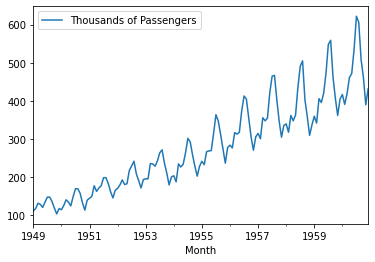

In [6]:
airline.plot()

Based on this chart, it looks like the trend in the earlier days is increasing at a higher rate than just linear (although it is a bit hard to tell from this one plot).

#### We can use seasonal decomposition to decompose the plot

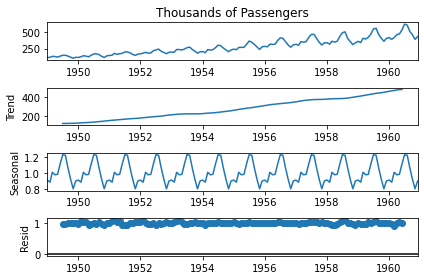

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(airline['Thousands of Passengers'], model='mul')  # model='mul' also works
result.plot();

**Trend plot** shows the general direction of the data 

**Seasonal plot** describes seasonality of the data, here You can see what seems to be even to perfect example of that.

**Residual plot** shows the *white noises* of the data, the things that make it so it doesn't perfectly match our model

## Moving averages

### SMA - Simple moving average

A *simple moving average* is created by appllying a mean function to a rolling window.

In [8]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()

We just created the so called *rolling window* of 6 months length and applied *mean* function to it. We will also create a simmilar SMA but of length 12, to compare the results.

In [9]:
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()

In [10]:
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


Remembering what we learned so far we drop the NA values, while doing so don't forget to type *inplace=<b>True* as the argument. Otherwise the operation won't persist!

In [11]:
airline.dropna(inplace=True)

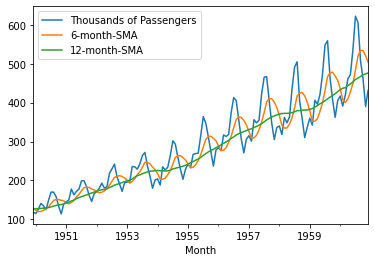

In [12]:
airline.plot();

**6-month-SMA** gives away more info about the growing size of peaks and the rate of it, but the **12-month-SMA** is better regarding the general tendency of the data, or so called *trend*. From that we can easily and with some confidence tell that the data is linearly growing, as oposed to growing exponentially. 

### EWMA - Exponentially Weighted Moving Average

We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:
- Smaller windows will lead to more noise, rather than signal
- It will always lag by the size of the window
- It will never reach to full peak or valley of the data due to the averaging.
- Does not really inform you about possible future behavior, all it really does is describe trends in your data.
- Extreme historical values can skew your SMA significantly

*EWMA* will allow us to reduce the lag effect from *SMA* and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the *EWMA* and the number of periods given a window size. Full details on Mathematics behind this can be found [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows). Here is the shorter version of the explanation behind *EWMA*.

The formula for *EWMA* is:
### $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

In [13]:
airline['EWMA12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()

#### Lets compare *EWMA* & *SMA* models

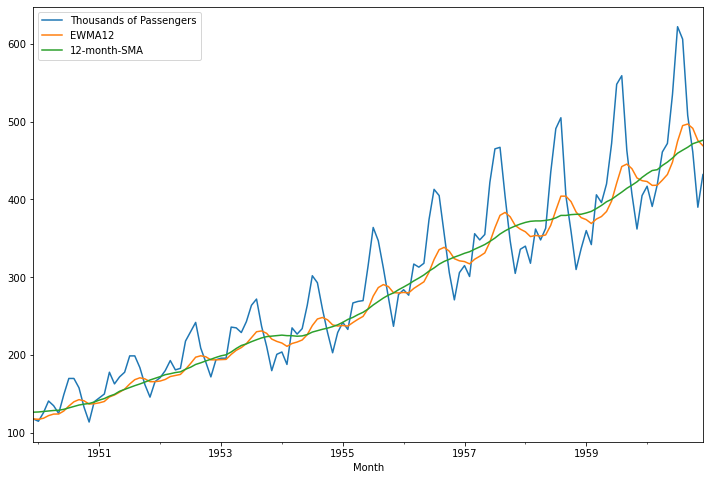

In [14]:
airline[['Thousands of Passengers','EWMA12','12-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

As we can see the *EWMA* does a pretty bad job of forecasting the data, that is due to the trend which we can easily pick up from the *SMA* model and the seasonality that we observed before, while performing the decomposition.

# Holt-Winters Methods

### Why is it less likely to fail, than the previous methods?

***EWMA*** did a better job, than the ***SMA*** model, but due to having only one smoothing factor $\alpha$ it lacked the capability to capture **trend** and **seasonality**. Before we used <em>Simple Exponential Smoothing</em>, not it's time for the **<em>Double</em>** and **<em>Triple Exponential Smoothing</em>** that are used with the **Holt-Winters Method**.

In <strong>Double Exponential Smoothing</strong> (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.



In [15]:
df = pd.read_csv('../Data/airline_passengers.csv',index_col='Month',parse_dates=True)

In [16]:
df.dropna(inplace=True)

In [17]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

### Setting a DatetimeIndex Frequency
Note that our DatetimeIndex does not have a frequency. In order to build a Holt-Winters smoothing model, statsmodels needs to know the frequency of the data (whether it's daily, monthly etc.). Since observations occur at the start of each month, we'll use MS.<br>A full list of time series offset aliases can be found <a href='http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases'>here</a>.

In [18]:
df.index.freq = 'MS'
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [19]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### Its important to add, that Holt-Winters Methods can be performed using *Simple Exponential Smooting*, just like we did before, but there is very little reason for that.

In [20]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()
df['SES12']=SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861


## Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

*We will start with the additive model*

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['DESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.102394
1949-02-01,118,112.923077,112.923077,120.040657
1949-03-01,132,115.857988,115.857988,134.001539
1949-04-01,129,117.879836,117.879836,131.085845
1949-05-01,121,118.359861,118.359861,123.110263


Lets see the plot of the data

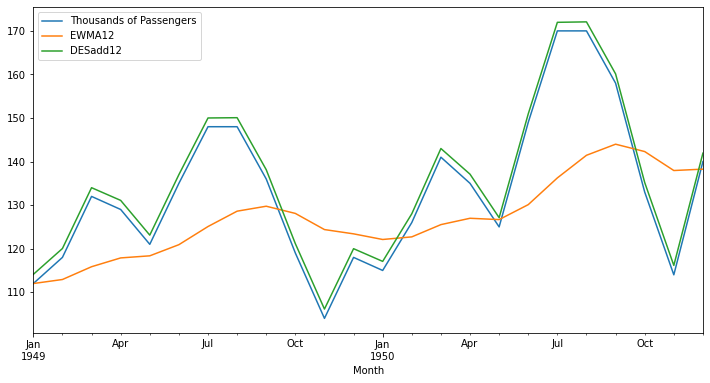

In [22]:
df[['Thousands of Passengers','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

**We can already see why double exponential smoothing is better at forecasting**


Now we will change the model to **multiplicative** and compare the two

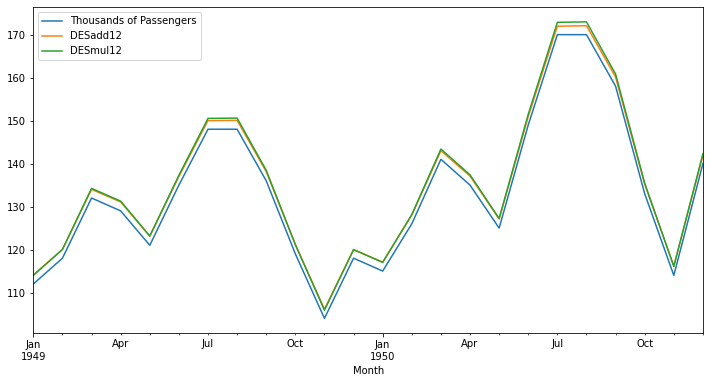

In [23]:
df['DESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df[['Thousands of Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

It's really hard to tell which one is better, as be can observe on the picks additive model does the better job, but on the slopes it is the opposite.

## Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 


In [24]:
df['TESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,
1949-01-01,112,112.000000,112.000000,114.102394,113.990701,112.034175,111.591127
1949-02-01,118,112.923077,112.923077,120.040657,120.031669,120.198998,118.838169
1949-03-01,132,115.857988,115.857988,134.001539,134.235979,134.709356,133.330402
1949-04-01,129,117.879836,117.879836,131.085845,131.270786,131.397488,127.898656
1949-05-01,121,118.359861,118.359861,123.110263,123.156267,124.641271,120.979274


*Lets see a plot of that*

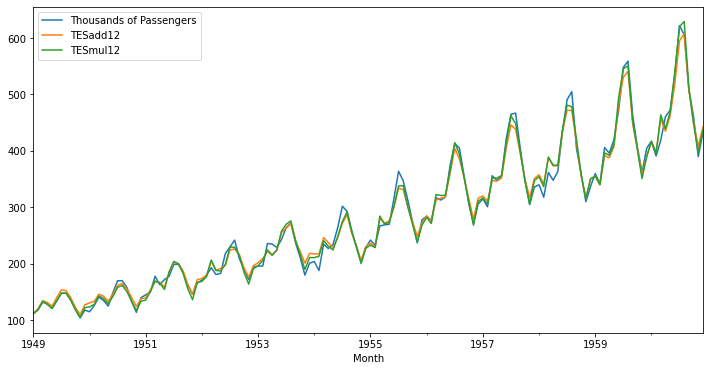

In [25]:
df[['Thousands of Passengers','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

*We will have to zoom in to see any pattern, we will start with the last 24 months*

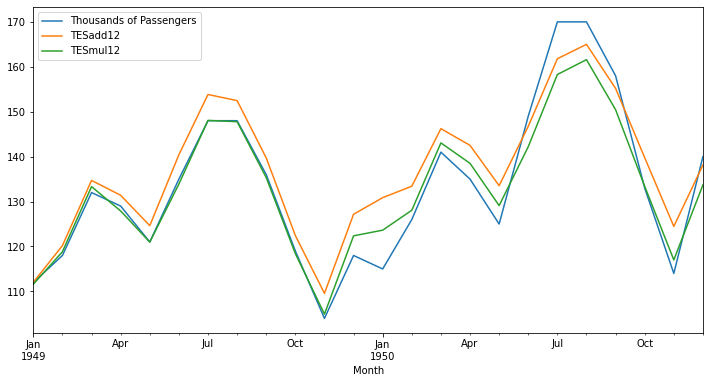

In [26]:
df[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

It may seem like <strong>*Triple exponential smoothing*</strong> is worse than <strong>*Double exponential smoothing*</strong> but the ability to take into consideration the seasonality factor can and will come in handy in **forecasting**.

## Something ends

That is just about all if it comes to *purely statistical models* (*that I know of*)

Lets now scratch a surface of the thing we builded up for - **forecasting**. A strange hybrid of *statistical models*, *machine learning* and a fair share of good old *integration*. Here we will focus on the basics needed to start

## Something begins

### Introduction to ARIMA Models
We'll investigate a variety of different forecasting models in upcoming sections, but they all stem from ARIMA.

<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<strong>Moving Averages</strong> we've already seen with EWMA and the Holt-Winters Method.<br>
<strong>Integration</strong> will apply differencing to make a time series stationary, which ARIMA requires.<br>
<strong>Autoregression</strong> is explained in detail in the next section. Here we're going to correlate a current time series with a lagged version of the same series.<br>
Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

### What is a grid search?
Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. It is an exhaustive search that is performed on a the specific parameter values of a model. The model is also known as an estimator.



# Summary 
Minimum level of knowladge You should have at this point:
- You can tell what is MA model family, how it works and why do we use it
- You know why EWMA is sometimes better and what it does without getting into details
- You understand the basics of Holt-Winters methods
- You understand the basics of ARIMA model family and why it is better at firecasting the future than the previously mentioned methods

# Bibliography:
- [Guide to TSA](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)
- [Article of the company specialized TSA](https://www.tableau.com/learn/articles/time-series-analysis#:~:text=What%20is%20time%20series%20analysis,data%20points%20intermittently%20or%20randomly.)
- Great course and the main source of above work: [Udemy course](https://www.udemy.com/course/python-for-time-series-data-analysis/)